In [32]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


In [33]:
df = pd.read_csv('data/SBAnational.csv', dtype='unicode')


In [34]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [35]:
df = df[['Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv','MIS_Status']]


In [36]:
# Ne prend en compte que les deux premiers chiffres des codes
df['NAICS'] = df['NAICS'].apply(lambda x: int(str(x)[:2]))

In [37]:
# Données manquantes
df.isnull().sum()

Name               14
City               30
State              14
Zip                 0
Bank             1559
BankState        1566
NAICS               0
ApprovalDate        0
ApprovalFY          0
Term                0
NoEmp               0
NewExist          136
CreateJob           0
RetainedJob         0
FranchiseCode       0
UrbanRural          0
RevLineCr        4528
LowDoc           2582
GrAppv              0
MIS_Status       1997
dtype: int64

In [38]:
# Les doublons
df.duplicated().sum()

232

In [39]:
# Supprimer le signe dollar 
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('$', ''))

# supprimer la virgule
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace(',', ''))

# supprimer le point
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('.', ''))

# Convertir en int
df['GrAppv'] = df['GrAppv'].astype(int)    

In [40]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Name           899150 non-null  object
 1   City           899134 non-null  object
 2   State          899150 non-null  object
 3   Zip            899164 non-null  object
 4   Bank           897605 non-null  object
 5   BankState      897598 non-null  object
 6   NAICS          899164 non-null  int64 
 7   ApprovalDate   899164 non-null  object
 8   ApprovalFY     899164 non-null  object
 9   Term           899164 non-null  object
 10  NoEmp          899164 non-null  object
 11  NewExist       899028 non-null  object
 12  CreateJob      899164 non-null  object
 13  RetainedJob    899164 non-null  object
 14  FranchiseCode  899164 non-null  object
 15  UrbanRural     899164 non-null  object
 16  RevLineCr      894636 non-null  object
 17  LowDoc         896582 non-null  object
 18  GrAp

In [41]:
y = df['MIS_Status']
X = df.drop(columns=['MIS_Status'], axis=1)

In [42]:
df.shape

(899164, 20)

In [43]:
# Secteurs du NAICS
secteurs = {
    11 : 'Agriculture, forest, fishing',
    21 : 'Mining, oil, Gaz',
    22 : 'Utilities',
    23 : 'Construction',
    31 : 'Manufacturing',
    32 : 'Manufacturing',
    33 : 'Manufacturing',
    42 : 'Wolesale trade',
    44 : 'Retail trade',
    45 : 'Retail trade',
    48 : 'Transportation and warehousing',
    49 : 'Transportation and warehousing',
    51 : 'Information',
    52 : 'Finance and insurance',
    53 : 'Real estate and rental, leasing',
    54 : 'Professional, scientific, technical services',
    55 : 'Management of companies and entreprises',
    56 : 'Administrative and support',
    61 : 'Educational services',
    62 : 'Health care and social',
    71 : 'Arts, entertainment',
    81 : 'Other services',
    92 : 'Public administration'
}

In [44]:
# Colonne qui indique les secteurs du NAICS
df['Sectors'] = df['NAICS'].map(secteurs)


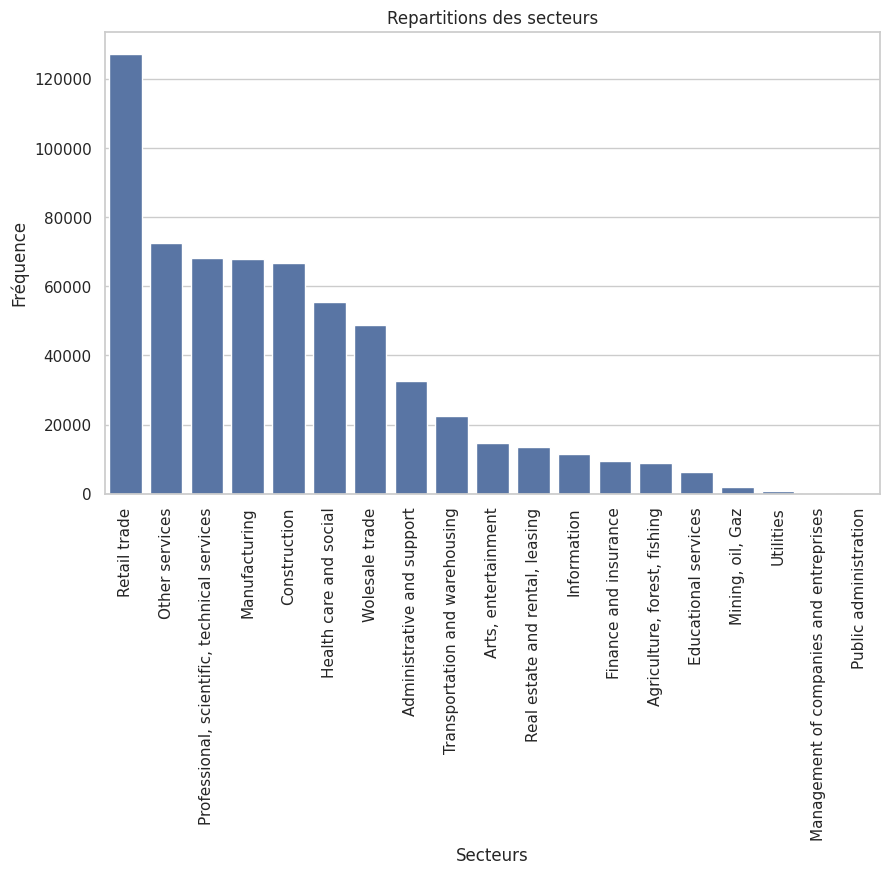

In [45]:
sector_counts = df['Sectors'].value_counts()

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Repartitions des secteurs')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

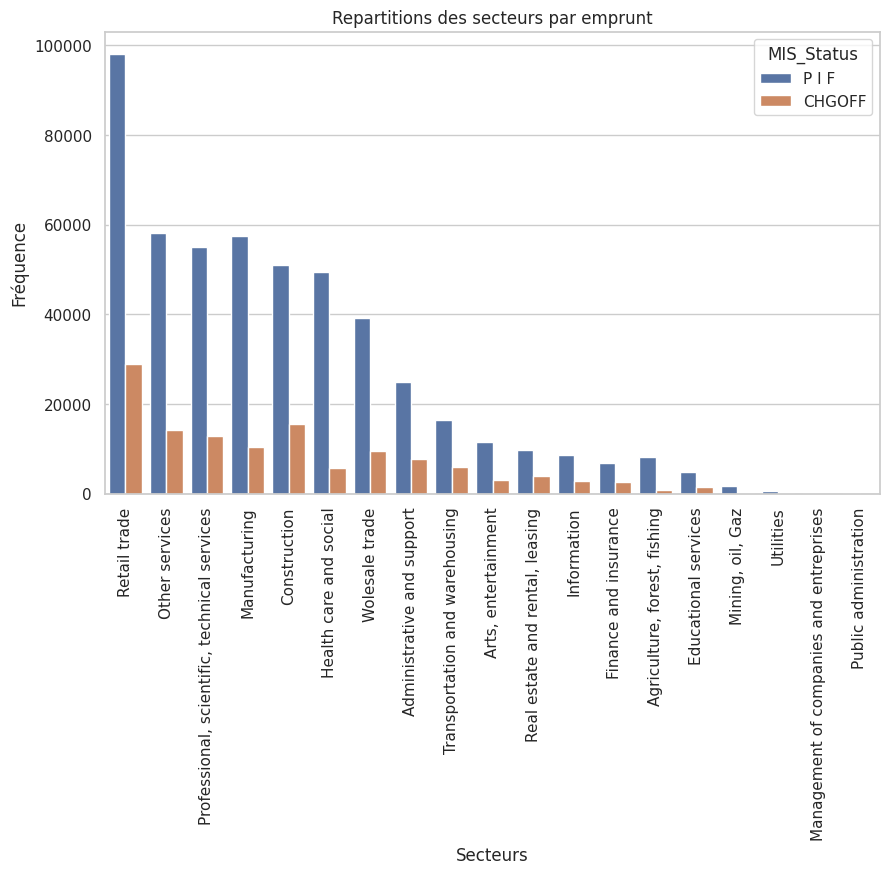

In [46]:
sector_counts = df['Sectors'].value_counts()
order = sector_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='Sectors', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions des secteurs par emprunt')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

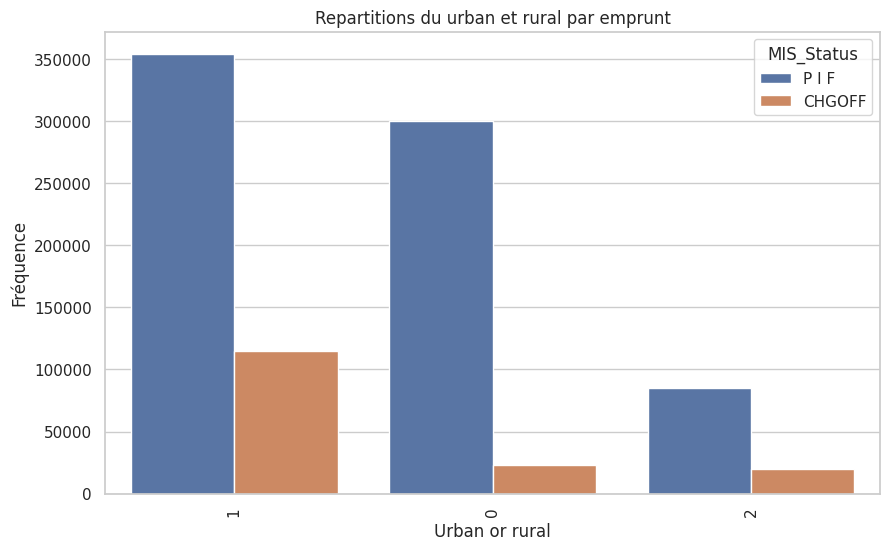

In [47]:
urban_counts = df['UrbanRural'].value_counts()
order = urban_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='UrbanRural', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions du urban et rural par emprunt')
plt.xlabel('Urban or rural')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

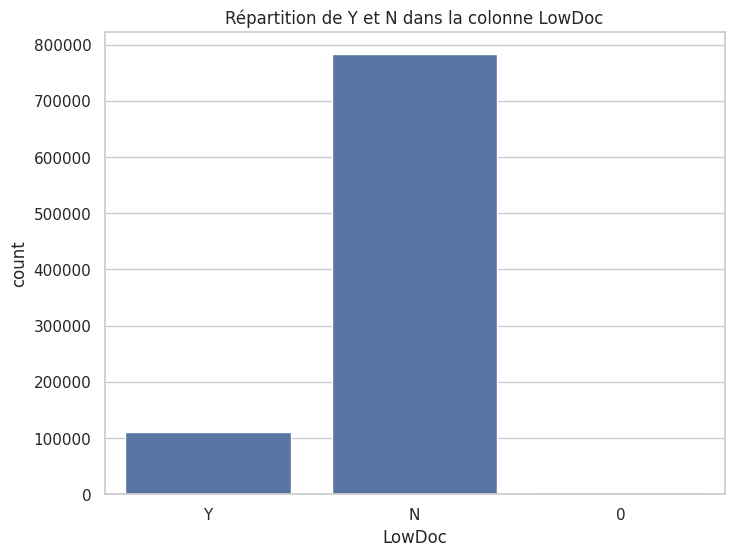

In [48]:
df['LowDoc'] = df['LowDoc'].replace({'C' : 0, '1' : 0, 'S' : 0, 'R' : 0, 'A' : 0})

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='LowDoc', data=df)

plt.title('Répartition de Y et N dans la colonne LowDoc')
plt.show()

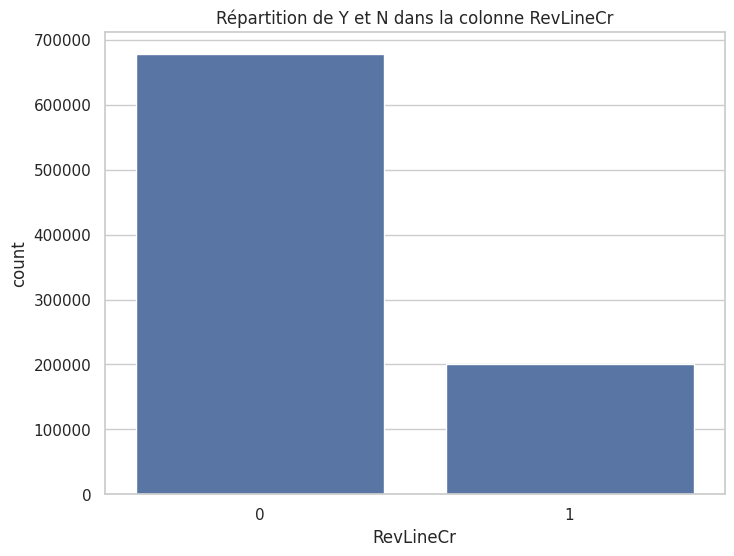

In [49]:
df['RevLineCr'] = df['RevLineCr'].replace(to_replace=r'[^N0Y]', value=np.nan, regex=True)
df['RevLineCr'] = df['RevLineCr'].replace({'Y':1, 'N':0})
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='RevLineCr', data=df)

plt.title('Répartition de Y et N dans la colonne RevLineCr')
plt.show()

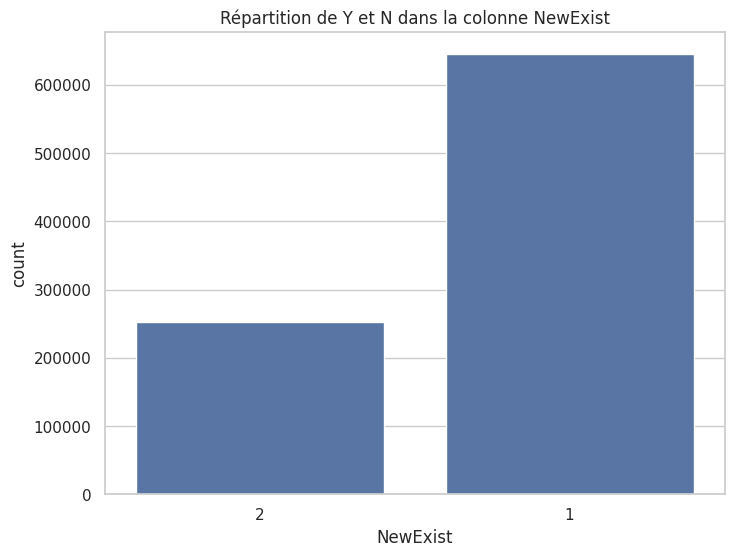

In [50]:
df['NewExist'] = df['NewExist'].replace({'0' : None})
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='NewExist', data=df)

plt.title('Répartition de Y et N dans la colonne NewExist')
plt.show()

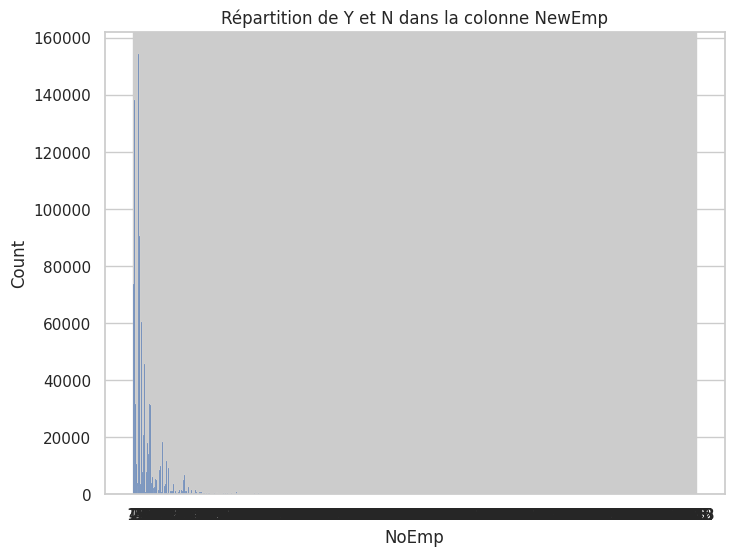

In [51]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.histplot(x=df['NoEmp'], data=df)

plt.title('Répartition de Y et N dans la colonne NewEmp')
plt.show()

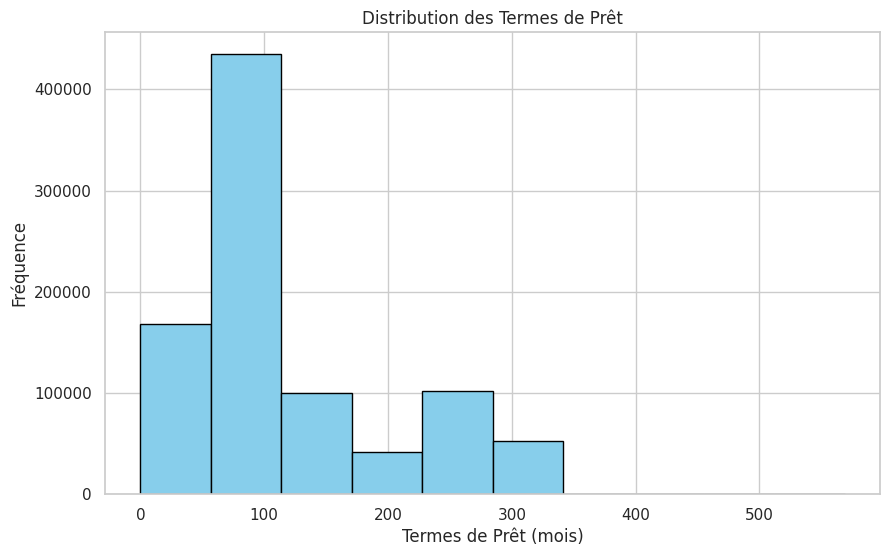

In [52]:
df['Term'] = pd.to_numeric(df['Term'], errors='coerce')

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['Term'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Termes de Prêt')
plt.xlabel('Termes de Prêt (mois)')
plt.ylabel('Fréquence')
plt.show()

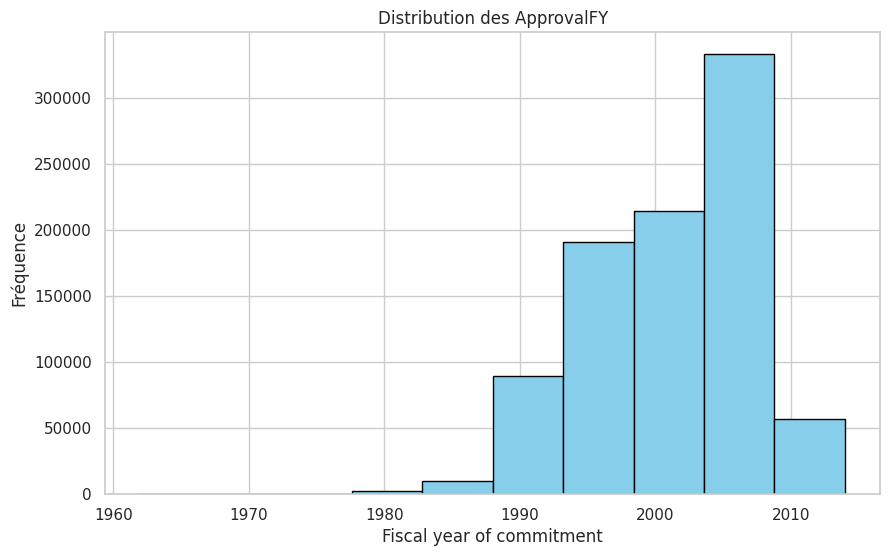

In [53]:
df['ApprovalFY'] = df['ApprovalFY'].astype(str).str.extract('(\d+)', expand=False)
df['ApprovalFY'] = df['ApprovalFY'].fillna(0).astype(int)

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalFY'].dropna(), color='skyblue', edgecolor='black')
plt.title('Distribution des ApprovalFY')
plt.xlabel('Fiscal year of commitment')
plt.ylabel('Fréquence')
plt.show()

In [54]:
# Convertir 'ApprovalDate' en format de date
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')



/tmp/ipykernel_83811/2010965532.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')


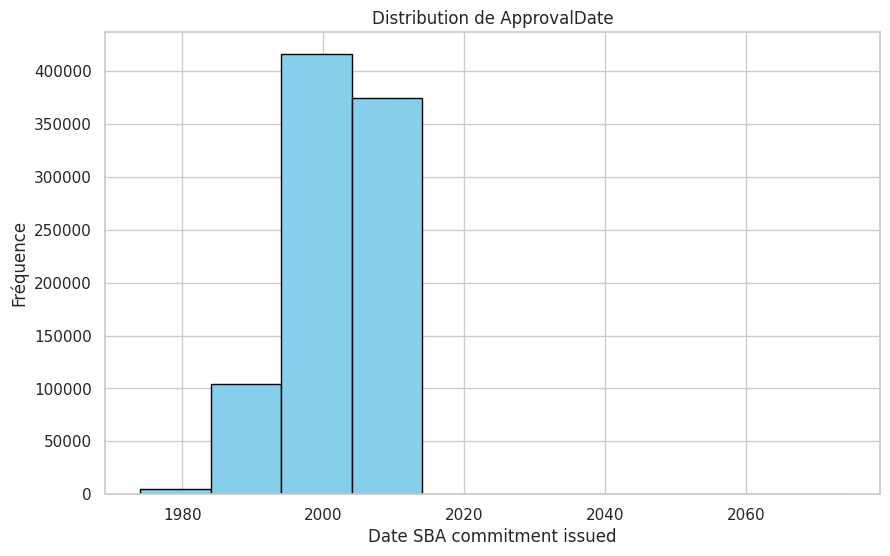

In [55]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalDate'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution de ApprovalDate')
plt.xlabel('Date SBA commitment issued')
plt.ylabel('Fréquence')
plt.show()

In [56]:
df.isna()

Name                 14
City                 30
State                14
Zip                   0
Bank               1559
BankState          1566
NAICS                 0
ApprovalDate          0
ApprovalFY            0
Term                  0
NoEmp                 0
NewExist           1170
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr         19877
LowDoc             2582
GrAppv                0
MIS_Status         1997
Sectors          269548
dtype: int64